# Boston Housing, Probabilistic Bayesian Neural Networks

## Load data

In [1]:
import tensorflow as tf

(X, y), _ = tf.keras.datasets.boston_housing.load_data(
    path='boston_housing.npz', 
    test_split=0.0, 
    seed=37
)

X.shape, y.shape

2022-10-13 10:27:35.095742: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-13 10:27:35.199312: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-13 10:27:35.655399: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64
2022-10-13 10:27:35.655481: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: can

((506, 13), (506,))

In [2]:
import numpy as np

def split(X, y, tr=0.8, tu=0.1, te=0.1, seed=37):
    N = len(X)
    indices = np.arange(N)
    
    rng = np.random.RandomState(seed)
    rng.shuffle(indices)
    
    X = X[indices]
    y = y[indices]

    n_tr = int(N * tr)
    n_tu = int(N * tu)
    n_te = int(N * te)
    
    idx_tr = 0, n_tr
    idx_tu = n_tr, n_tr + n_tu
    idx_te = n_tr + n_tu, N
    
    X_tr = np.array(X[idx_tr[0]:idx_tr[1]])
    X_tu = np.array(X[idx_tu[0]:idx_tu[1]])
    X_te = np.array(X[idx_te[0]:idx_te[1]])
    
    y_tr = np.array(y[idx_tr[0]:idx_tr[1]])
    y_tu = np.array(y[idx_tu[0]:idx_tu[1]])
    y_te = np.array(y[idx_te[0]:idx_te[1]])
    
    return X_tr, y_tr, X_tu, y_tu, X_te, y_te
    
X_tr, y_tr, X_tu, y_tu, X_te, y_te = split(X, y)

X_tr.shape, y_tr.shape, X_tu.shape, y_tu.shape, X_te.shape, y_te.shape

((404, 13), (404,), (50, 13), (50,), (52, 13), (52,))

## Scale data

In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_tr)

X_tr = scaler.transform(X_tr)
X_tu = scaler.transform(X_tu)
X_te = scaler.transform(X_te)

X_tr.shape, y_tr.shape, X_tu.shape, y_tu.shape, X_te.shape, y_te.shape

((404, 13), (404,), (50, 13), (50,), (52, 13), (52,))

## Prepare data

In [4]:
from tensorflow.data import Dataset

SAMPLES_TR = X_tr.shape[0]
SAMPLES_TU = X_tu.shape[0]
SAMPLES_TE = X_te.shape[0]

N_BATCHES = 10
BATCH_SIZE_TR = np.floor(SAMPLES_TR / N_BATCHES)
BATCH_SIZE_TU = 1
BATCH_SIZE_TE = 1

D_tr = Dataset.from_tensor_slices((X_tr, y_tr)) \
    .shuffle(SAMPLES_TR, reshuffle_each_iteration=True) \
    .batch(BATCH_SIZE_TR)

D_tu = Dataset.from_tensor_slices((X_tu, y_tu)) \
    .shuffle(SAMPLES_TU) \
    .batch(BATCH_SIZE_TU)

D_te = Dataset.from_tensor_slices((X_te, y_te)) \
    .shuffle(SAMPLES_TE) \
    .batch(BATCH_SIZE_TE)

2022-10-13 10:29:03.186989: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 10:29:03.210276: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 10:29:03.210440: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 10:29:03.210813: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

## Model

In [5]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, BatchNormalization
import tensorflow_probability as tfp

FEATURE_NAMES = [
    'CRIM',
    'ZN',
    'INDUS',
    'CHAS',
    'NOX',
    'RM',
    'AGE',
    'DIS',
    'RAD',
    'TAX',
    'PTRATIO',
    'B',
    'LSTAT'
]

def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = keras.Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.MultivariateNormalDiag(
                    loc=tf.zeros(n), scale_diag=tf.ones(n)
                )
            )
        ]
    )
    return prior_model

def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = keras.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
            ),
            tfp.layers.MultivariateNormalTriL(n),
        ]
    )
    return posterior_model

def get_model():
    prior = tfp.distributions.Independent(
        tfp.distributions.Normal(loc=tf.zeros(1, dtype=tf.float32), scale=1.0), 
        reinterpreted_batch_ndims=1
    )
    
    model = Sequential([
        InputLayer(input_shape=(len(FEATURE_NAMES),), name='input'),
        Dense(10, activation='relu', name='dense_1'),
        Dense(
            tfp.layers.MultivariateNormalTriL.params_size(1), 
            activation=None, 
            name='distribution_weights'
        ),
        tfp.layers.MultivariateNormalTriL(
            1, 
            activity_regularizer=tfp.layers.KLDivergenceRegularizer(
                prior, 
                weight=1/N_BATCHES
            ), 
            name='output'
        )
    ], name='model')
    
    return model

def get_model(train_size=BATCH_SIZE_TR):
    model = Sequential([
        InputLayer(input_shape=(len(FEATURE_NAMES),), name='input'),
        BatchNormalization(),
        tfp.layers.DenseVariational(
            units=8,
            make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight=1 / train_size,
            activation='sigmoid',
        ),
        tfp.layers.DenseVariational(
            units=8,
            make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight=1 / train_size,
            activation='sigmoid',
        ),
        Dense(units=2),
        tfp.layers.IndependentNormal(1)
    ], name='model')
    
    return model

model = get_model()

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


In [6]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 13)               52        
 ormalization)                                                   
                                                                 
 dense_variational (DenseVar  (None, 8)                6440      
 iational)                                                       
                                                                 
 dense_variational_1 (DenseV  (None, 8)                2700      
 ariational)                                                     
                                                                 
 dense (Dense)               (None, 2)                 18        
                                                                 
 independent_normal (Indepen  ((None, 1),              0         
 dentNormal)                  (None, 1))                     

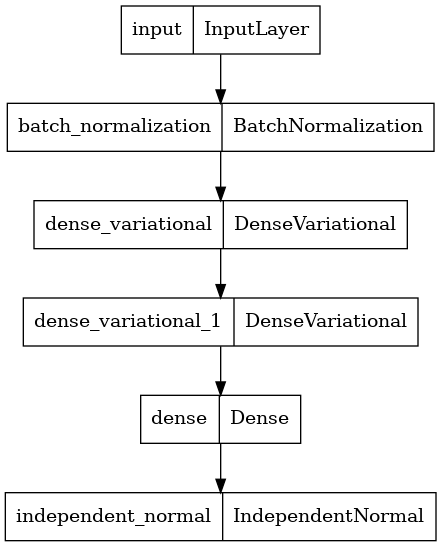

In [7]:
from tensorflow import keras

keras.utils.plot_model(model)

## Compile model

In [8]:
def negative_loglikelihood(targets, estimated_distribution):
    return -estimated_distribution.log_prob(targets)

model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
    loss=negative_loglikelihood,
    metrics=[keras.metrics.RootMeanSquaredError()],
)

## Fit model

In [9]:
%%time
hist = model.fit(
    x=D_tr,
    validation_data=D_tu,
    epochs=5_000, 
    verbose=0
)

CPU times: user 11min 18s, sys: 49.2 s, total: 12min 7s
Wall time: 7min 32s


## Evaluate

In [10]:
import pandas as pd

_, mae_tr = model.evaluate(D_tr, verbose=0)
_, mae_tu = model.evaluate(D_tu, verbose=0)
_, mae_te = model.evaluate(D_te, verbose=0)

pd.Series({
    'mae_tr': mae_tr,
    'mae_tu': mae_tu,
    'mae_te': mae_te
})

mae_tr    10.770439
mae_tu     9.368629
mae_te     9.837456
dtype: float64

## Predictions

In [11]:
sample = 10
examples, targets = list(D_te.unbatch().shuffle(256 * 10).batch(sample))[0]

dist_pred = model(examples)
mean_pred = dist_pred.mean().numpy().tolist()
stdv_pred = dist_pred.stddev().numpy()

upper = (mean_pred + (1.96 * stdv_pred)).tolist()
lower = (mean_pred - (1.96 * stdv_pred)).tolist()
stdv_pred = stdv_pred.tolist()

for idx in range(sample):
    print(
        f'Prediction mean: {round(mean_pred[idx][0], 2)}, '
        f'stddev: {round(stdv_pred[idx][0], 2)}, '
        f'95% CI: [{round(lower[idx][0], 2)}, {round(upper[idx][0], 2)}]'
        f' - Actual: {targets[idx]}'
    )

Prediction mean: 21.75, stddev: 7.0, 95% CI: [8.03, 35.47] - Actual: 22.2
Prediction mean: 27.17, stddev: 8.68, 95% CI: [10.16, 44.19] - Actual: 32.9
Prediction mean: 27.32, stddev: 8.73, 95% CI: [10.21, 44.44] - Actual: 31.5
Prediction mean: 27.23, stddev: 8.7, 95% CI: [10.18, 44.28] - Actual: 33.1
Prediction mean: 23.53, stddev: 7.55, 95% CI: [8.74, 38.33] - Actual: 20.9
Prediction mean: 19.17, stddev: 6.14, 95% CI: [7.13, 31.2] - Actual: 17.1
Prediction mean: 22.58, stddev: 7.27, 95% CI: [8.33, 36.82] - Actual: 18.6
Prediction mean: 20.23, stddev: 6.5, 95% CI: [7.49, 32.97] - Actual: 20.8
Prediction mean: 19.06, stddev: 6.1, 95% CI: [7.1, 31.02] - Actual: 17.8
Prediction mean: 25.7, stddev: 8.23, 95% CI: [9.56, 41.83] - Actual: 22.9


## Performance

In [12]:
SAMPLES = X_te.shape[0]
ITERATIONS = 100

test_iterator = tf.compat.v1.data.make_one_shot_iterator(D_te)
X_true = np.empty(shape=(SAMPLES, len(FEATURE_NAMES)))
Y_true = np.empty(shape=(SAMPLES, 1))
Y_pred = np.empty(shape=(SAMPLES, 1, ITERATIONS))

for i in range(SAMPLES):
    features, labels = test_iterator.get_next()
    X_true[i,:] = features
    Y_true[i,:] = labels.numpy()
    for k in range(ITERATIONS):
        Y_pred[i,:,k] = model.predict(features, verbose=0)
        
Y_pred_m = np.mean(Y_pred, axis=-1)
Y_pred_s = np.std(Y_pred, axis=-1)

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_df = pd.DataFrame({
    'y_true': Y_true.reshape(1, -1)[0],
    'y_pred': Y_pred_m.reshape(1, -1)[0],
    'y_std': Y_pred_s.reshape(1, -1)[0]
    }) \
    .assign(
        y_lower=lambda d: d['y_pred'] - d['y_std'],
        y_upper=lambda d: d['y_pred'] + d['y_std']
    ) \
    .sort_values(['y_true', 'y_pred', 'y_std']) \
    .reset_index(drop=True)

pd.Series({
    'mae': mean_absolute_error(y_df['y_true'], y_df['y_pred']),
    'rmse': mean_squared_error(y_df['y_true'], y_df['y_pred'], squared=False),
    'rsq': r2_score(y_df['y_true'], y_df['y_pred'])
})

mae     4.586565
rmse    6.198089
rsq     0.436954
dtype: float64

In [14]:
y_df[['y_true', 'y_pred']].corr()

,y_true,y_pred
y_true,1.000000,0.690947
y_pred,0.690947,1.000000


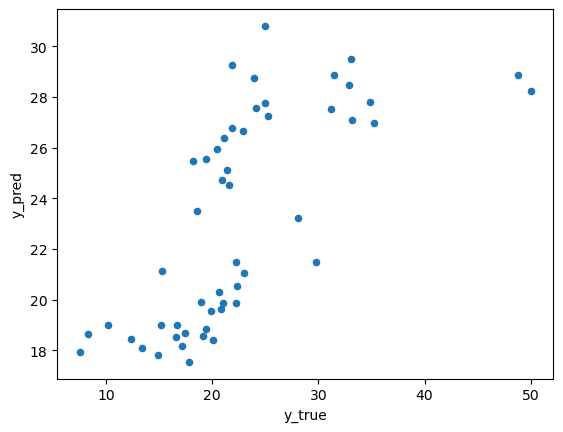

In [15]:
_ = y_df.plot(kind='scatter', x='y_true', y='y_pred')

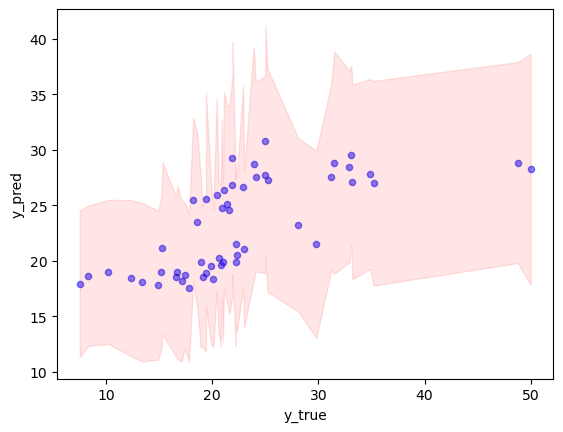

In [16]:
ax = y_df.plot(kind='scatter', x='y_true', y='y_pred', color='blue', alpha=0.5)
ax.fill_between(y_df['y_true'], y_df['y_lower'], y_df['y_upper'], color='red', alpha=0.1)